The goal of this notebook is to write code that given a specific nucleus to produce, an efficiency will be calculated based on the required input energy, target cross sections, and power density of the product to find the optimal use of radionuclide production as a method of energy storage. 

This can also be used to generate a theoretical maximum of storage efficiency for each product. 

To start, we'll need cross sections. 

Will attempt to download the entirety of (or write a very fast query for) 
https://doi.org/10.1016/j.nds.2018.02.001

Pivoting to use Jeff32 since it has a singular directory with many neutron cross sections for different targets. https://www.oecd-nea.org/dbforms/data/eva/evatapes/jeff_32/

JENDL appears to have both neutron and proton cross section data for transmutation, so this seems very promising. It uses the ENDF6 format https://www-nds.iaea.org/public/endf/ 

Finally found the database explorer for ENDF, will be using this as well. 
https://www-nds.iaea.org/exfor/e4explorer.htm 

#Derivations for nuclide production
Consider a target $T$ with a cross section $\sigma$ at an energy level of $E_{particle}$. We have for the production rate (from "Industrial Accelerators and their Applications")
\begin{equation}
\frac{dR}{dx} = In\sigma
\end{equation}
Integrating, we have for the number of nuclei produced
\begin{equation}
N = \int\int\frac{dR}{dx}dxdt = \int\int In\sigma dxdt
\end{equation}
Where $R$ is the production rate in atoms per second, $x$ is the depth of the material, $n$ is the nuclei/volume, and $\sigma$ is the cross section in area/nucleus, and $I$ is the flow rate in moles/second of the beam. It's also important to note that the beam energy is also a function of $x$. Thus we have for the energy input 
\begin{equation}
E_{in} = \int IE_{incident \ particle} dt
\end{equation}
For a given decay chain whose parent nucleus has $N$ particles we have for a pure amount of this substance a specific energy (energy density) $\rho_{E}$ of 
\begin{equation}
E_{out} = Z_{product}N\rho_{E}
\end{equation}
where $Z$ is the mass number of the product and $N_A$ is Avogadro's constant. 
Thus we have for the energy efficiency of this process, 
\begin{equation}
\frac{E_{out}}{E_{in}} = \frac{Z_{product}N\rho_{E}}{\int IE_{incident \ particle} dt} =  
\frac{Z_{product}\rho_{E}\int\int In\sigma dxdt}{\int IE_{incident \ particle} dt}
\end{equation}

##Thin target case with constant beam current and energy
\begin{equation}
\frac{E_{out}}{E_{in}} = \frac{Z_{product}\rho_{E} In\sigma xt}{IE_{incident \ particle}t} = \frac{Z\rho_{E} n\sigma x}{E_{incident \ particle}}
\end{equation}
Rearranging to find the energy efficiency per thickness of material 
\begin{equation}
\frac{E_{out}}{xE_{in}} = \frac{Z_{product}\rho_{E} n\sigma }{E_{incident \ particle}}
\end{equation}
Thus, our figure of merit for a reaction will be energy efficiency per thickness of material. 
We'll be dealing with a lot of data and computations so I'll use Julia instead of Python. 

In [2]:
using Unitful #https://painterqubits.github.io/Unitful.jl/stable/
#quantity * @u_str("unit abbreviation") 
using Symbolics #https://symbolics.juliasymbolics.org/dev/
#cite https://doi.org/10.48550/arXiv.2105.03949
using Latexify
using Test
#1 * @u_str("mA") is 1 milliamp
using CSV, DataFrames
using Plots
using Printf
#plotlyjs()
data_dir = ("C:\\Cross-Section-Data\\")

"C:\\Cross-Section-Data\\"

#ENDF6

For each section of file 3 (reaction cross sections) the format of each column is 

[MAT, 3, MT/ ZA, AWR, 0, 0, 0, 0] HEAD

[MAT, 3, MT/ QM, QI, 0, LR, NR, NP/ Eint/ σ(E)]TAB1

[MAT, 3, 0/ 0.0, 0.0, 0, 0, 0, 0] SEND

where 

This function creates a properly formatted matrix of 64 bit floats from the file path of an ENDF6 formatted text file.

Use list comprehension to check if each line (in the form of a string) is in the valid data format, take only those rows, and convert each of them to a matrix, which is then converted into two vectors.

In [113]:
# Reference: https://github.com/DavidWalz/pyENDF6

slices = Dict(
    "MAT" => 67:71,
    "MF" => 72:74,
    "MT" => 75:78,
    "line" => 78:83,
    "content" => 1:67,
    "data" => [a-10:a for a in 11*collect(1:6)])


function read_float(v)
    #Convert ENDF6 string to float 
    a, b = [' '], "" 
    if (strip(v, a) == b)
        return 0.
    end
    try
        return parse(Float64, v)
    catch
        # ENDF6 may omit the e for exponent
        return parse(Float64,
            v[1] * replace(replace(v[2:end], "+" => "e+"), "-" => "e-"))  # don't replace leading negative sign
    end
end  

function read_line(l)
    #Read first 6*11 characters of a line as floats"""
    return [read_float(l[s]) for s in slices["data"]]
end
 
function read_table(lines)
    #=
    Parse tabulated data in a section
    https://t2.lanl.gov/nis/endf/intro07.html
    https://t2.lanl.gov/nis/endf/intro08.html
    https://t2.lanl.gov/nis/endf/intro09.html
    =#
    # header line 1: (100*Z+A), mass in [m_neutron]
    # [MAT, 3, MT/ ZA, AWR, 0, 0, 0, 0] HEAD

    # header line 2: Q-value and some counts
    # [MAT, 3, MT/ QM, QI, 0, LR, NR, NP/ EINT/ S(E)] TAB1
    f = read_line(lines[2])
    nS = Int64(f[5])  # number of interpolation sections
    nP = Int64(f[6])  # number of data points
    # header line 3: interpolation information
    # [MAT, 3, 0/ 0.0, 0.0, 0, 0, 0, 0] SEND
    # 1   y is constant in x (constant, histogram)
    # 2   y is linear in x (linear-linear)
    # 3   y is linear in ln(x) (linear-log)
    # 4   ln(y) is linear in x (log-linear)
    # 5   ln(y) is linear in ln(x) (log-log)
    # 6   y obeys a Gamow charged-particle penetrability law

    # data lines
    x = []
    y = []
    for l in lines[4:end]
        f = read_line(l)
        append!(x, f[1], f[3], f[5])
        append!(y, f[2], f[4], f[6])
    end
    return x[1:nP], y[1:nP]
end 

function find_section(lines, MF, MT)
    #"""Locate and return a certain section"""
    v = [l[71:75] for l in lines]
    cmpstr = "$(@sprintf("%2s", MF))$(@sprintf("%3s", MT))" # search string
    i0 = collect(findfirst(==(cmpstr), v))[1] # first occurrence
    i1 = collect(findlast(==(cmpstr), v))[1] # last occurrence
    return lines[i0: i1]
end

find_section (generic function with 1 method)

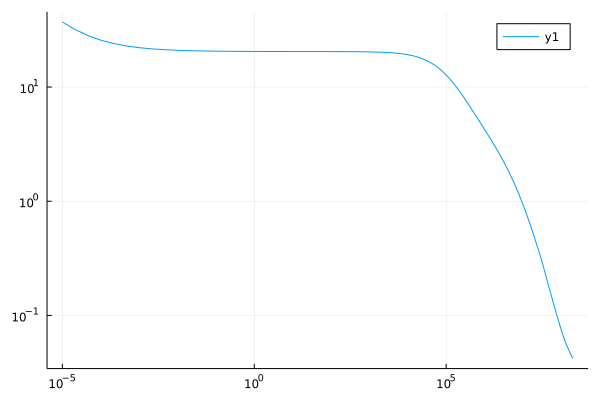

In [115]:
file_path = data_dir  * String("jendl5-n\\n_001-H-001.dat")
open(file_path) do file
    lines = split(read(file_path, String), "\n", keepempty = false)
    lines = lines[lines .!== nothing]
    lines = lines[lines .!== ""]
    lines = lines[lines .!== Nothing]
    lines = String.(lines)
    sec = find_section(lines, 3, 1)
    x, y = read_table(sec)
    plot(x, y, xaxis=:log, yaxis=:log)
end
#df = DataFrame(CSV.File(file_path, delim=' ', ignorerepeated=true, 
#           header=false))[:,1:6]
#make array from all odd numbered columns

In [176]:
function reaction_figure_of_merit(energy_density, mass_number, target_nuclei_per_area, sigma, 
incident_particle_energy)
    #For the product, we take the mass number to be equal to the molar mass
    figure_of_merit = (energy_density * mass_number * 
        target_nuclei_per_area * sigma) / incident_particle_energy
    return uconvert(Unitful.NoUnits, figure_of_merit) 
end

ρ, Z, n, σ, E = @variables ρ, Z, n, σ, E
output = ρ * Z * n * σ / E
print("For output = ", output, "       (unitless)")
Test.@test reaction_figure_of_merit(ρ * @u_str("J/g"), Z * @u_str("g"), 
    n * (@u_str("cm")^-2), σ * @u_str("cm")^2, E * @u_str("J")) - output == 0

For output = (Z*n*ρ*σ) / E       (unitless)

Test Passed
  Expression: reaction_figure_of_merit(ρ * u"J/g", Z * u"g", n * u"cm" ^ -2, σ * u"cm" ^ 2, E * u"J") - output == 0
   Evaluated: 0 == 0

In [13]:
dir = "C:\\Cross-Section-Data\\"
print("Data directory: ", dir)
files = readdir(dir)
files

Data directory: C:\Cross-Section-Data\Data directory: C:\Cross-Section-Data\

7-element Vector{String}:
 ".git"
 ".gitattributes"
 "E4R4949_e4.txt"
 "JEFF32N"
 "README.md"
 "jendl5-n"
 "jendl5-p"

In [15]:
neutron_dir = dir * "jendl5-n\\"

"C:\\Cross-Section-Data\\jendl5-n\\"

In [24]:
import ENDF6
import plotly.express as px
path = "C:\\Cross-Section-Data\\jendl5-n\\n_001-H-001.dat"
f = open(path)
lines = f.readlines()
sec = ENDF6.find_section(lines, MF=3, MT=1)  # total cross-section
x, y = ENDF6.read_table(sec)
px.scatter(x=x, y=y, labels = {'x':"Photon energy [eV]", 'y' : "Cross-section [barn]"},
log_x = True, log_y = True)


In [21]:
import numpy as np
index = np.argmax(x/y)
x[index], y[index]

(200000000.0, 0.0420456)